In [120]:
# https://github.com/jin-s13/COCO-WholeBody
# https://cocodataset.org/#download
# https://cocodataset.org/#keypoints-2017

# Sources

# new dataset: 
# https://github.com/Fang-Haoshu/Halpe-FullBody

# https://github.com/nicknochnack/FaceDetection/blob/main/FaceDetection.ipynb
# https://towardsdatascience.com/bounding-box-prediction-from-scratch-using-pytorch-a8525da51ddc

# http://shuoyang1213.me/WIDERFACE/
# https://github.com/jin-s13/COCO-WholeBody/blob/master/data_format.md

# https://pytorch.org/hub/pytorch_vision_vgg/


In [121]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2
from tqdm import tqdm
from datetime import datetime

from PIL import Image, ImageStat

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from torchvision.models import vgg16
from torchvision import models
from PIL import Image

# TODO: Not all operations in VGG16 work on mps
device = "cpu"#"mps" if torch.backends.mps.is_available() else "cpu"

from NotebookNotifications.Notifications import notify

In [122]:
image_folder = "data/hico_20160224_det/images/train2015/"
save_folder = 'results/visualizations/'

In [123]:
f = open("data/halpe_train_v1.json")
annotations_dict = json.load(f)

In [124]:
imgs = {}
for img in annotations_dict['images']:
    imgs[img['id']] = img

In [125]:
desired_keypoints = [17,18]

X_all = []
y_all = []
z_all = []
# yclass_all = []

def is_grayscale(im):
    stat = ImageStat.Stat(im)
    return len(stat.sum) != 3


for idx, annot in tqdm(enumerate(annotations_dict['annotations'])):
    if 'keypoints' in annot and type(annot['keypoints']) == list:

        imgname = str(imgs[annot['image_id']]['file_name'])

        kp = np.array(annot['keypoints'])
        kp_x = kp[0::3]
        kp_y = kp[1::3]
        kp_scores = kp[2::3]
        
        img = Image.open(image_folder + imgname)            

        all_above_threshold = np.all(0.6 <= kp_scores[desired_keypoints])
        # if not all_above_threshold or img.mode == "L":
        #     continue
        if img.mode == "L":
            continue


        y = np.array([])
        for n in desired_keypoints:
            cor_x, cor_y = int(kp_x[n]), int(kp_y[n])
            y_ = np.array([cor_x / img.size[0], cor_y / img.size[1]])
            y = np.concatenate((y, y_), axis=0)

        X_all.append(img)
        y_all.append(y)
        z_all.append(int(all_above_threshold))

        if 1000 <= len(X_all):
            break
        

1012it [00:00, 2222.54it/s]


In [126]:
# for idx, annot in tqdm(enumerate(annotations_dict['annotations'])):
#     if 50 < idx:
#         break
#     if 'keypoints' in annot and type(annot['keypoints']) == list:
#         imgname = str(imgs[annot['image_id']]['file_name'])
        
#         if os.path.exists(os.path.join(save_folder, imgname)):
#             img = cv2.imread(os.path.join(save_folder, imgname))
#         else:
#             img = cv2.imread(os.path.join(image_folder, imgname))
#         part_line = {}
#         kp = np.array(annot['keypoints'])
#         kp_x = kp[0::3]
#         kp_y = kp[1::3]
#         kp_scores = kp[2::3]
        
#         # Draw keypoints
#         for n in [17,18]: #range(kp_scores.shape[0]): #
#             if kp_scores[n] <= 0.6:
#                 continue
#             cor_x, cor_y = int(kp_x[n]), int(kp_y[n])
#             part_line[n] = (int(cor_x), int(cor_y))
#             if n < len(p_color):
#                 cv2.circle(img, (int(cor_x), int(cor_y)), 2, p_color[n], -1)
#             else:
#                 cv2.circle(img, (int(cor_x), int(cor_y)), 1, (255,255,255), 2)
#         # Draw limbs
#         # for i, (start_p, end_p) in enumerate(l_pair):
#         #     if start_p in part_line and end_p in part_line:
#         #         start_xy = part_line[start_p]
#         #         end_xy = part_line[end_p]
#         #         if i < len(line_color):
#         #             cv2.line(img, start_xy, end_xy, line_color[i], 2)
#         #         else:
#         #             cv2.line(img, start_xy, end_xy, (255,255,255), 1)

#         cv2.imwrite(os.path.join(save_folder,imgname),img)

In [127]:
def GlobalMaxPool2D(x):
    x = torch.functional.F.adaptive_max_pool2d(x, (1, 1))
    return x.reshape(x.size(0), -1)


# Define model
class FaceNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = models.vgg16(weights='DEFAULT')

        # Classification model
        self.classifier = nn.Sequential(
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

        # Regression model
        self.reggression = nn.Sequential(
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4),
            nn.Sigmoid()
        )


    # Set your own forward pass
    def forward(self, x, extra_info=None):
        x = self.model.features(x)

        x = GlobalMaxPool2D(x)

        # Classify
        logits = self.classifier(x)
        positions = self.reggression(x)

        return (logits, positions)

model = FaceNet().to(device)
# print(model)

In [128]:

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

X = [preprocess(im).unsqueeze(0) for im in X_all]
X = torch.cat(X, axis=0)
y = torch.Tensor(y_all)
z = torch.Tensor(z_all).reshape(-1, 1)


tensor([1.]) tensor([0.5234, 0.0304, 0.6187, 0.1335])


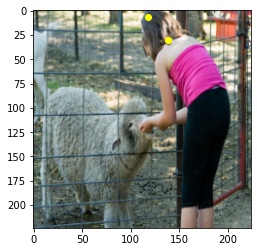

In [129]:
i = 23
print(z[i], y[i])
im = X[i].numpy()
_, w, h = im.shape
im = im.swapaxes(0,1)
im = im.swapaxes(1,2)
plt.imshow(im)
plt.scatter(x = y[i][::2] * w, y = y[i][1::2] * h, color='yellow')
plt.show()

In [130]:
full_dataset = torch.utils.data.TensorDataset(X, y, z)

train_pct = 0.8

train_size = int(train_pct * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [131]:
def train_loop(dataloader, model, class_loss_fn, localization_loss_fn, optimizer):
    size = len(dataloader.dataset)

    for batch, (X, y, z) in enumerate(train_dataloader):

        # Compute prediction and loss
        z_pred, y_pred = model(X)

        class_loss = class_loss_fn(z_pred, z)
        box_loss = localization_loss_fn(y_pred, y)
        loss = class_loss + box_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [132]:
def test_loop(dataloader, model, class_loss_fn, localization_loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y, z in dataloader:
            z_pred, y_pred = model(X)
            test_loss += class_loss_fn(z_pred, z).item()
            correct += z_pred.eq(z).sum().item()#(z_pred.argmax(1) == z).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [133]:
class_loss_fn = nn.BCELoss()
localization_loss = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(),lr = 0.1)

epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, class_loss_fn, localization_loss, optimizer)
    test_loop(train_dataloader, model, class_loss_fn, localization_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.930097  [    0/  800]
loss: 15.675326  [  320/  800]
loss: 6.286606  [  640/  800]
Test Error: 
 Accuracy: 85.9%, Avg loss: 13.750000 

Epoch 2
-------------------------------
loss: 12.554073  [    0/  800]
loss: 15.672465  [  320/  800]
loss: 6.283775  [  640/  800]
Test Error: 
 Accuracy: 85.9%, Avg loss: 13.750000 

Epoch 3
-------------------------------
loss: 12.550829  [    0/  800]
loss: 15.669871  [  320/  800]
loss: 6.281423  [  640/  800]
Test Error: 
 Accuracy: 86.0%, Avg loss: 13.750000 

Epoch 4
-------------------------------
loss: 12.548688  [    0/  800]
loss: 15.667504  [  320/  800]
loss: 6.279184  [  640/  800]
Test Error: 
 Accuracy: 86.1%, Avg loss: 13.750000 

Epoch 5
-------------------------------
loss: 12.547112  [    0/  800]
loss: 15.664957  [  320/  800]
loss: 6.277044  [  640/  800]
Test Error: 
 Accuracy: 86.2%, Avg loss: 13.750000 

Epoch 6
-------------------------------
loss: 12.544764  [    0/  800]
loss:

In [134]:
# def get_num_correct(preds, labels):
#     return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

# def train(model):
#     # Defining the optimizer
#     optimizer = torch.optim.SGD(model.parameters(),lr = 0.1)
#     num_of_epochs = 4
#     epochs = []
#     losses = []

#     # Creating a directory for storing models
#     os.makedirs('models', exist_ok=True)
#     for epoch in range(num_of_epochs):
#         tot_loss = 0
#         tot_correct = 0

#         model.train()

#         for batch, (x, y, z) in enumerate(train_dataloader):
#         	# Converting data from cpu to GPU if available to improve speed
#             x, y, z = x.to(device), y.to(device), z.to(device)

#             # Sets the gradients of all optimized tensors to zero
#             optimizer.zero_grad()
#             [z_pred, y_pred] = model(x)

#             # Compute loss
#             class_loss = F.binary_cross_entropy(z_pred, z)
#             box_loss = F.mse_loss(y_pred, y)
#             (box_loss + class_loss).backward()

#             optimizer.step()
#             print(f"Train Batch: {batch+1}/{len(train_dataloader)}. Epoch: {epoch}/{num_of_epochs}", end='\r')

#         model.eval()

#         for batch, (x, y,z) in enumerate(test_dataloader):
#         	# Converting data from cpu to GPU if available to improve speed	
#             x,y,z = x.to(device),y.to(device),z.to(device)

#             # Sets the gradients of all optimized tensors to zero
#             optimizer.zero_grad()
#             with torch.no_grad():
#                 [z_pred, y_pred] = model(x)
                
#                 # Compute loss
#                 class_loss = F.binary_cross_entropy(z_pred, z)
#                 box_loss = F.mse_loss(y_pred, y)

#             tot_loss += (class_loss.item() + box_loss.item())
#             tot_correct += get_num_correct(z_pred, z)
#             print(f"Test Batch: {batch+1}/{len(test_dataloader)}. Epoch: {epoch}/{num_of_epochs}", end='\r')

#         epochs.append(epoch)
#         losses.append(tot_loss)
#         print(f"Epoch: {batch+1}/{len(train_dataloader)}. Accuracy: {tot_correct/len(z):.2f}. Loss: {tot_loss:.2f}", end='\r')

#     timestamp = datetime.now().strftime("%m_%d_%Y_%H:%M:%S")
#     torch.save(model.state_dict(), f"models/model_{timestamp}.pth")

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.4835, 0.1802, 0.4540, 0.2753]], grad_fn=<SigmoidBackward0>)


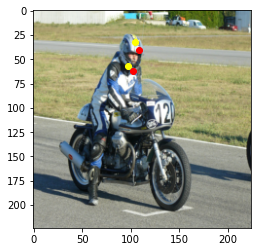

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.4199, 0.1442, 0.3387, 0.6426]], grad_fn=<SigmoidBackward0>)


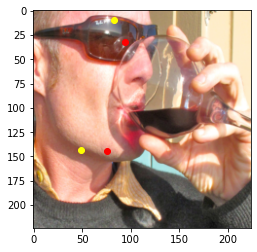

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.5649, 0.4096, 0.5801, 0.5043]], grad_fn=<SigmoidBackward0>)


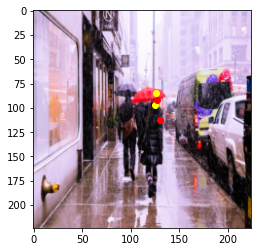

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.4966, 0.2045, 0.6224, 0.4404]], grad_fn=<SigmoidBackward0>)


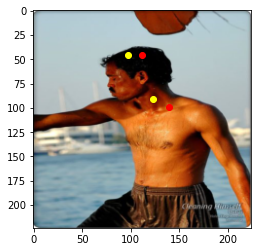

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.7529, 0.7174, 0.7040, 0.7088]], grad_fn=<SigmoidBackward0>)


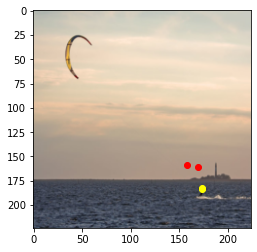

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.7977, 0.3414, 0.8142, 0.3791]], grad_fn=<SigmoidBackward0>)


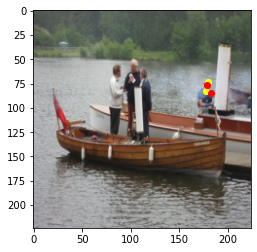

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.0518, 0.0326, 0.0865, 0.0578]], grad_fn=<SigmoidBackward0>)


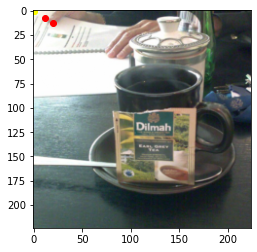

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.7648, 0.3464, 0.7699, 0.4772]], grad_fn=<SigmoidBackward0>)


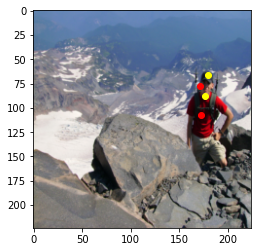

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.5161, 0.3625, 0.5398, 0.3939]], grad_fn=<SigmoidBackward0>)


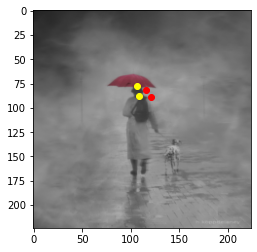

tensor([[1.]], grad_fn=<SigmoidBackward0>)
tensor([[0.1717, 0.1472, 0.1187, 0.1251]], grad_fn=<SigmoidBackward0>)


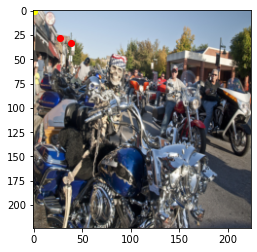

In [135]:
# Sanity check
for i in range(10):
    # print("true")
    # print(z[i], y[i], end="\n\n")
    # print("preds:")
    preds = model(train_dataloader.dataset[i][0].unsqueeze(0))
    pos = preds[1].detach().numpy()[0]
    for res in preds:
        print(res)

    im = train_dataloader.dataset[i][0].numpy()
    _, w, h = im.shape
    im = im.swapaxes(0,1)
    im = im.swapaxes(1,2)
    plt.imshow(im)
    plt.scatter(x = train_dataloader.dataset[i][1][::2] * w, y = train_dataloader.dataset[i][1][1::2] * h, color='yellow')
    plt.scatter(x = pos[::2] * w, y = pos[1::2] * h, color='red')
    plt.show()